<h1 div class='alert alert-info alert-dismissible'><center> Ponto de partida (EDA)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

A edição de maio do problema de classificação binária da série Tabular Playground de 2022 que inclui várias interações de variáveis diferentes, as variáveis são dados de fabricação simulados que devem ser usados para prever o estado binário (alvo) da máquina que é 0/1. 

A motivação não é apenas prever o estado da máquina com as variáveis simuladas, mas também descobrir a interação de 'ocultas' que pode ajudar a melhorar a precisão da previsões.

Esta competição é uma oportunidade para explorar vários métodos que ajudem a identificar essas interações entre as variáveis. 

Fora isso, a página de descrição de dados informa que os dados incluem dados contínuos normalizados e dados categóricos.


# <div class="alert alert-info alert-dismissible">  OBJETIVO </div> 

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados
- Calculando estatísticas sobre o conjunto de dados
- Visualização univariada
- Visualizando multivariada
- Pré-processamento 




---

# <div class="alert alert-info alert-dismissible">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    #!pip install --q pycaret

    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import shap

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scipy.stats       as stats

In [4]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing   import PowerTransformer, RobustScaler, Normalizer
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn                 import metrics
from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix

In [5]:
from datetime                import datetime

---

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [6]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [7]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [8]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [9]:
def graf_label(ax, total):
    
     for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        width, height = i.get_width() -.2 , i.get_height()
        
        x, y  = i.get_xy()  
        color = 'white'
        alt   = .5
        soma  = 0 

        if height < 70:
            color = 'black'
            alt   = 1
            soma  = 10

        ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                    (i.get_x()+.3*width, 
                     i.get_y()+soma + alt*height),
                     color   = color,
                     weight = 'bold',
                     size   = 14)

In [10]:
def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
    #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
    ax     = df    
    colors = col
    
    if tol == 0: 
        total  = sum(ax)
        ax = (ax).plot(kind    ='bar',
                       stacked = True,
                       width   = .5,
                       rot     = 0,
                       color   = colors, 
                       grid    = False)
    else:
        total  = tol     
        
        ax = (ax).plot(kind    ='bar',
                       stacked = True,
                       width   = .5,
                       rot     = 0,
                       figsize = (10,6),
                       color   = colors,
                       grid    = False)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    #y_fmt = tick.FormatStrFormatter('%.0f') 
    #ax.yaxis.set_major_formatter(y_fmt)

    title   = title #+ ' \n'
    xlabel  = '\n ' + xlabel 
    ylabel  = ylabel + ' \n'
    
    ax.set_title(title  , fontsize=22)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)    

    min = [0,23000000]
    #ax.set_ylim(min)
    
    graf_label(ax, total)

In [11]:
def calc_erro(y, y_pred, outros=True, ruturn_score=False):
    erro   = smape(y, y_pred)    
      
    
    if outros:        
        rmse = metrics.mean_squared_error(y, y_pred, squared=False)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        mae  = metrics.mean_absolute_error(y, y_pred)
        
        print('RMSE : {:2.5f}'.format(rmse))
        print('MAE  : {:2.5f}'.format(mae))
        print('MAPE : {:2.5f}'.format(mape))
        
        
    if ruturn_score: 
        return erro
    else: 
        print('SMAPE: {:2.5f}'.format(erro))

In [12]:
def df_corr(df, annot_=False, method_='pearson'):
    
    df = df.corr(method=method_).round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(15,12))
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [13]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [14]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [15]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [16]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

In [18]:
#define the smape function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [19]:
def linear_fit_slope(y):
    """Return the slope of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return slope

In [20]:
def linear_fit_intercept(y):
    """Return the intercept of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return intercept

In [21]:
def cromer_v(x, y):
    cm       = pd.crosstab(x, y).to_numpy()        
    n        = cm.sum()
    r, k     = cm.shape
    chi2     = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
    kcorr    = k - (k-1) **2/(n-1)
    rcorr    = r - (r-1) **2/(n-1)    
    v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
    return v  

In [22]:
def generate_category_table(data):

    cols    = data.select_dtypes(include='object').columns
    dataset = pd.DataFrame()

    for i in cols:
        corr = []
        for x in cols: 
            corr.append(cromer_v(data[i],data[x]))

        aux     = pd.DataFrame({i:corr})
        dataset = pd.concat([dataset, aux], axis=1) 

    return dataset.set_index(dataset.columns)

In [23]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");
    
    if print_var: 
        print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        df_corr.columns =  ['var_1', 'var_2', 'corr']
        display(df_corr)

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for FLAI 08')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [25]:
def feature_engineering(df_):
    
    var_f27 = ''
    for col in df_['f_27']: 
        var_f27 +=col

    var_f27 = list(set(var_f27))
    var_f27.sort()
    
    df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))
    
    for letra in var_f27:             
        df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)
        
    return df_ 

---

## 1.4. Dataset

### 1.4.1. Descrição de dados

Para este desafio, temos um conjunto de dados de controle de fabricação (simulados) e temos a tarefa de prever se a máquina está em estado 0 ou estado 1, os dados têm várias interações de variáveis que podem ser importantes na determinação do estado da máquina, o qual devemos identificar para uma boa tareja de previsão. 


### 1.4.2. Arquivos
- **treino.csv**: conjunto de treinamento, que incluem dados contínuos normalizados e dados categóricos;
- **teste.csv**: conjunto de teste, a tarefa é prever um binário para target que representa o estado de um processo de fabricação
- **sample_submission.csv**: um arquivo de envio de amostra no formato correto

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [26]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param']

for path in paths:
    try:
        os.mkdir(path)       
    except:
        pass  

### 1.4.4. Carrega dados

In [27]:
path        = '/content/drive/MyDrive/kaggle/Tabular Playground Series/05 - Maio/' if COLAB else ''   
path        = ''
path_data   = 'Data/'  
target      = 'target'
path_automl = 'automl/'

In [28]:
df1_train     = pd.read_csv(path + path_data + 'train.csv')
df1_test      = pd.read_csv(path + path_data + 'test.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((900000, 33), (700000, 32), (700000, 2))

In [29]:
df1_train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [30]:
df1_test.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,0,0,5,1,1,2,2,0,1,-1.128371,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,0,2,1,3,0,0,0,2,0,-4.424098,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,1,1,3,2,2,4,1,0,3,-1.523864,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,2,1,5,0,3,3,1,4,2,-1.404597,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,0,0,3,0,1,2,0,2,2,-1.968516,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


---

### 1.3.1. Redução dos datasets

In [31]:
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

Mem. usage decreased to 50.64 Mb (77.7% reduction)
Mem. usage decreased to 38.72 Mb (77.3% reduction)


# <div class="alert alert-info alert-dismissible">2. Análise Exploratória de Dados (EDA)  </div> 

In [32]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

## 2.1. Dimensão do DataSet

In [33]:
print('TREINO')
print('Number of Rows: {}'.format(df2_train.shape[0]))
print('Number of Columns: {}'.format(df2_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df2_test.shape[0]))
print('Number of Columns: {}'.format(df2_test.shape[1]))

TREINO
Number of Rows: 900000
Number of Columns: 33

TESTE
Number of Rows: 700000
Number of Columns: 32


---

## 2.2. Tipo de dados

In [34]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int32  
 1   f_00    900000 non-null  float16
 2   f_01    900000 non-null  float16
 3   f_02    900000 non-null  float16
 4   f_03    900000 non-null  float16
 5   f_04    900000 non-null  float16
 6   f_05    900000 non-null  float16
 7   f_06    900000 non-null  float16
 8   f_07    900000 non-null  int8   
 9   f_08    900000 non-null  int8   
 10  f_09    900000 non-null  int8   
 11  f_10    900000 non-null  int8   
 12  f_11    900000 non-null  int8   
 13  f_12    900000 non-null  int8   
 14  f_13    900000 non-null  int8   
 15  f_14    900000 non-null  int8   
 16  f_15    900000 non-null  int8   
 17  f_16    900000 non-null  int8   
 18  f_17    900000 non-null  int8   
 19  f_18    900000 non-null  int8   
 20  f_19    900000 non-null  float16
 21  f_20    90

In [35]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      700000 non-null  int32  
 1   f_00    700000 non-null  float16
 2   f_01    700000 non-null  float16
 3   f_02    700000 non-null  float16
 4   f_03    700000 non-null  float16
 5   f_04    700000 non-null  float16
 6   f_05    700000 non-null  float16
 7   f_06    700000 non-null  float16
 8   f_07    700000 non-null  int8   
 9   f_08    700000 non-null  int8   
 10  f_09    700000 non-null  int8   
 11  f_10    700000 non-null  int8   
 12  f_11    700000 non-null  int8   
 13  f_12    700000 non-null  int8   
 14  f_13    700000 non-null  int8   
 15  f_14    700000 non-null  int8   
 16  f_15    700000 non-null  int8   
 17  f_16    700000 non-null  int8   
 18  f_17    700000 non-null  int8   
 19  f_18    700000 non-null  int8   
 20  f_19    700000 non-null  float16
 21  f_20    70

In [36]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df2_test.dtypes).value_counts()}')

=== For Pandas ==========
float16    16
int8       15
int32       1
object      1
dtype: int64

=== For Datatable =======
float16    16
int8       14
int32       1
object      1
dtype: int64


Vamos dar uma olhada nas variáveis do tipo int8.  

In [37]:
for col in df2_train.select_dtypes(np.int8).columns.drop(target):   
    num = df2_train[col].unique().tolist()
    num.sort()
    print('-'* 70)
    print('{} unique: {}'.format(col, num))    
    print('-'* 70)
    print()

----------------------------------------------------------------------
f_07 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_08 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_09 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_10 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
----------------------------------------------------------------------

----------------------------------------------------------------------
f_11 unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
---------------------------------

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Podemos observar que as variáveis acima segue um ordem, provavelmente foram transformadas em ordinal no processo de geração dos datasets, sendo assim, vamos transformá-las em categóricas para as nossas análises.
    
</div>

In [38]:
for col in df2_train.select_dtypes(np.int8).columns.drop(target):   
    df2_train[col] = df2_train[col].astype(object)   
    df2_test[col]  = df2_test[col].astype(object)    

In [39]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int32  
 1   f_00    900000 non-null  float16
 2   f_01    900000 non-null  float16
 3   f_02    900000 non-null  float16
 4   f_03    900000 non-null  float16
 5   f_04    900000 non-null  float16
 6   f_05    900000 non-null  float16
 7   f_06    900000 non-null  float16
 8   f_07    900000 non-null  object 
 9   f_08    900000 non-null  object 
 10  f_09    900000 non-null  object 
 11  f_10    900000 non-null  object 
 12  f_11    900000 non-null  object 
 13  f_12    900000 non-null  object 
 14  f_13    900000 non-null  object 
 15  f_14    900000 non-null  object 
 16  f_15    900000 non-null  object 
 17  f_16    900000 non-null  object 
 18  f_17    900000 non-null  object 
 19  f_18    900000 non-null  object 
 20  f_19    900000 non-null  float16
 21  f_20    90

In [40]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      700000 non-null  int32  
 1   f_00    700000 non-null  float16
 2   f_01    700000 non-null  float16
 3   f_02    700000 non-null  float16
 4   f_03    700000 non-null  float16
 5   f_04    700000 non-null  float16
 6   f_05    700000 non-null  float16
 7   f_06    700000 non-null  float16
 8   f_07    700000 non-null  object 
 9   f_08    700000 non-null  object 
 10  f_09    700000 non-null  object 
 11  f_10    700000 non-null  object 
 12  f_11    700000 non-null  object 
 13  f_12    700000 non-null  object 
 14  f_13    700000 non-null  object 
 15  f_14    700000 non-null  object 
 16  f_15    700000 non-null  object 
 17  f_16    700000 non-null  object 
 18  f_17    700000 non-null  object 
 19  f_18    700000 non-null  object 
 20  f_19    700000 non-null  float16
 21  f_20    70

---

## 2.3. Identificar NA

In [41]:
missing = missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 33 colunas e 900000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [42]:
missing = missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 32 colunas e 700000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Não temos valores ausentes. 
    
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [43]:
feature_float = df2_test.select_dtypes(np.number).columns.to_list()
feature_cat   = df2_test.select_dtypes(object).columns.to_list()

feature_float.remove('id')

msg = 'Temos {} variávies numéricas e {} categóricas.'
print(msg.format(len(feature_float), len(feature_cat)))

Temos 16 variávies numéricas e 15 categóricas.


- Train

In [44]:
df2_train.drop([target, 'id'], axis=1).describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
f_00,900000.000000,-0.000286,0.000000,-4.601562,-0.675293,0.001144,0.674316,4.750000
f_01,900000.000000,0.001165,0.000000,-4.683594,-0.675293,0.002014,0.674805,4.816406
f_02,900000.000000,0.001173,0.000000,-4.644531,-0.674316,0.002218,0.677734,4.960938
f_03,900000.000000,-0.001369,0.000000,-4.660156,-0.676270,-0.002228,0.672363,4.453125
f_04,900000.000000,-0.000573,0.000000,-4.750000,-0.675781,-0.001662,0.673828,4.949219
f_05,900000.000000,0.000285,0.000000,-4.750000,-0.673340,-0.000437,0.674805,4.972656
f_06,900000.000000,-0.000711,0.000000,-4.843750,-0.674805,-0.001492,0.674805,4.824219
f_19,900000.000000,nan,0.000000,-11.281250,-1.236328,0.330322,1.880859,12.078125
f_20,900000.000000,nan,0.000000,-11.257812,-1.804688,-0.190552,1.444336,11.476562
f_21,900000.000000,nan,0.000000,-13.312500,-1.820312,-0.152710,1.506836,14.453125


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Podemos observar que a maioria  das variáveis tem desvio padrão igual a zero, exceto a variável **f_28**, sendo assim, tem uma baixa variância.

Outro ponto em relação a variáveil **f_28** são os altos valores negativo e positivo nas estatísticas mínimo e  máximo, o interessante é que o valor mínimo e máximo são iguais e os valores de 25% e 75% são guase iguais.   
    
</div>

---

## 2.6. Distribuição

### 2.6.1. Train / Test

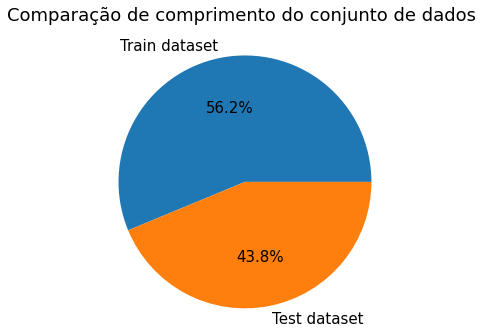

In [77]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             #colors   = ["teal", "b"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

---

### 2.6.2. Distribuição Train x Test

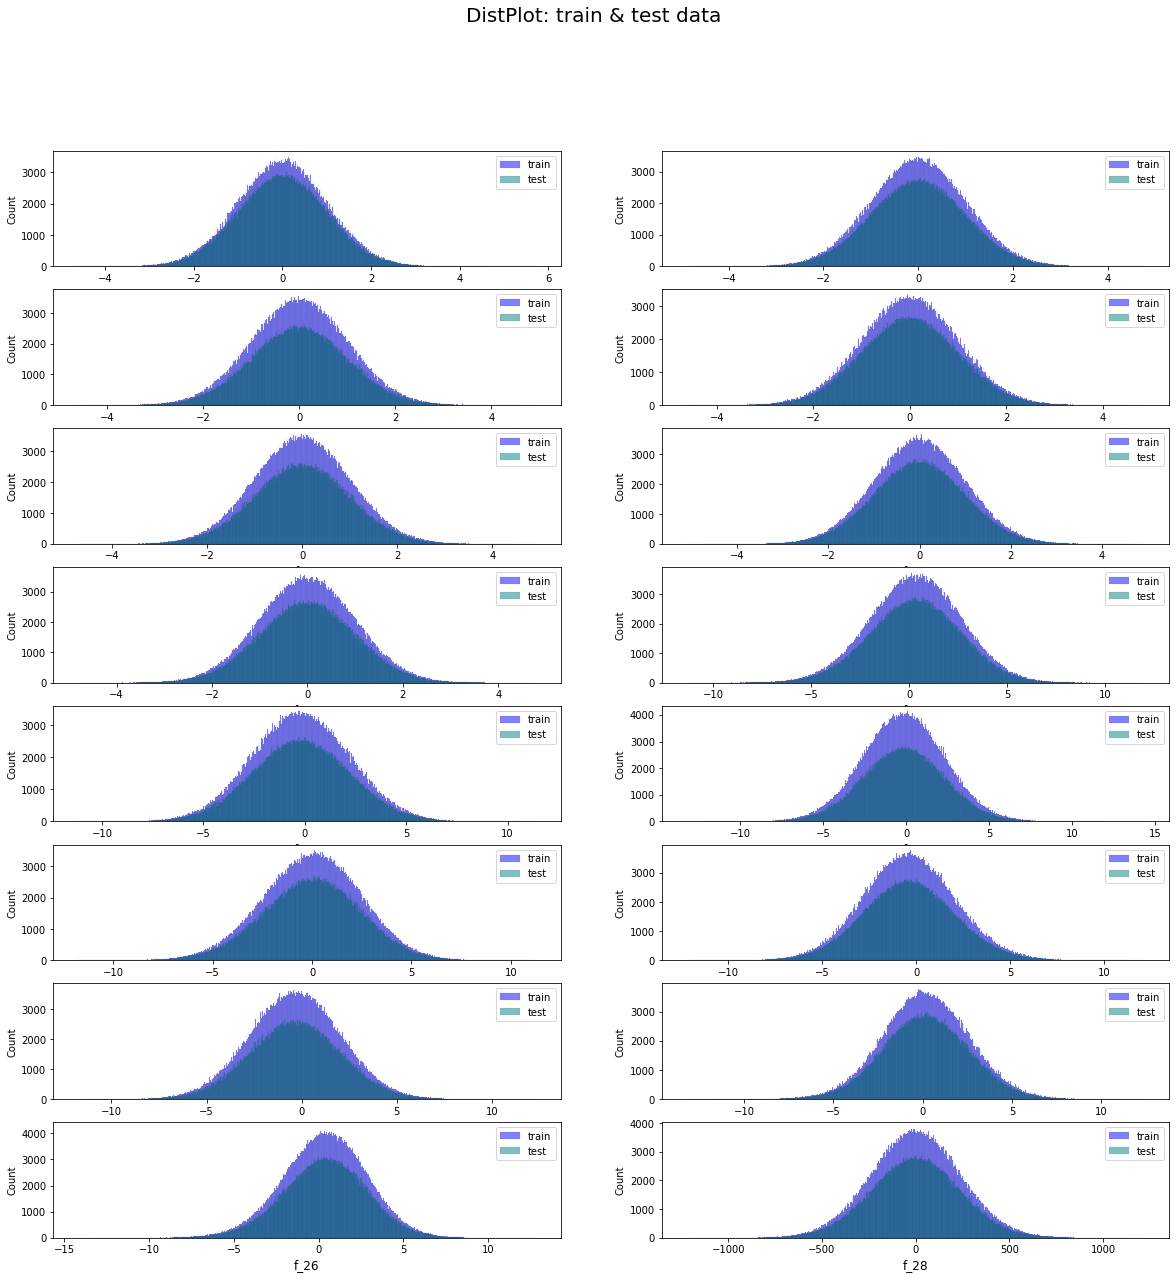

In [78]:
lines   = int(len(feature_float)/2)
fig, ax = plt.subplots(lines,2 ,figsize=(20,20))

for i,feature in enumerate(feature_float):
    plt.subplot(lines,2,i+1)
    sns.histplot(data=df2_train, x=df2_train[feature],color='blue', alpha=0.5, label='train', bins=1000)
    sns.histplot(data=df2_test , x=df2_test[feature] ,color='teal', alpha=0.5, label='test' , bins=1000)     
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('DistPlot: train & test data', fontsize=20);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Ambos os datasets seguem a mesma distribuição.

</div>

### 2.6.3. Proporção de variáveis

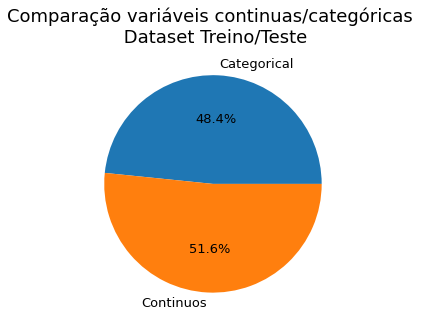

In [79]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

### 2.6.4. Distribuição da target

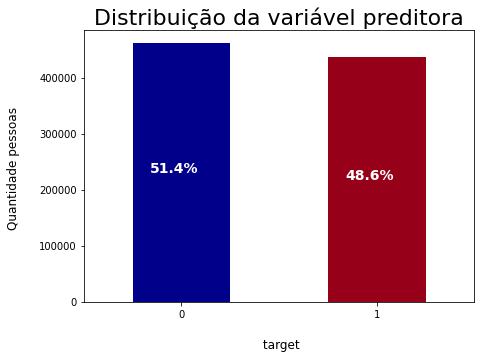

In [80]:
plt.figure(figsize=(7,5))    

graf_bar(df2_train.groupby([target])[target].count() , 
         icecream, 
         'Distribuição da variável preditora', 
         target, 
         'Quantidade pessoas');

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Não temos desbalanceamento nos dados. 
                                                       
</div>

## 2.7. Dados Categóricas

Vamos fazer uma contagem das observações e em cada variável categórica, para termos uma noção de como nosso conjunto de dados estar distribuído.

In [82]:
for i in feature_cat:
    print("Coluna: ",i)
    print(df2_train[[i]].value_counts(), "\n")

Coluna:  f_07
f_07
1       229008
2       205821
0       164173
3       144005
4        82936
5        41560
6        19221
7         8172
8         3322
9         1121
10         450
11         148
12          46
13          11
14           3
15           3
dtype: int64 

Coluna:  f_08
f_08
1       233896
2       217894
3       151369
0       143142
4        84719
5        40930
6        17385
7         6762
8         2565
9          883
10         321
11          88
12          20
13          16
14           8
16           2
dtype: int64 

Coluna:  f_09
f_09
2       223321
1       202211
3       173809
4       106760
0       100154
5        55154
6        24233
7         9383
8         3413
9         1084
10         342
11         103
12          24
13           8
14           1
dtype: int64 

Coluna:  f_10
f_10
2       214324
1       213454
3       158311
0       136995
4        95041
5        47814
6        21210
7         8453
8         2995
9          966
10         314
11       

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
A variável **f_27** precisa ser transformada, pois temos 741354 elementos únicos, isto é, criar novas variáveis apartir dessa variável, sendo assim, vamos excluí-la das análises neste primeiro momento e na parte de feature engineering vamos tratá-la.     <br>    
Agora temos uma noção de como estão distribuídas as categorias, temos colunas apresentam uma pequena concentração em uma única categoria, vamos fazer uma análise gráfica para tirar mais algumas informações.
    
</div>

In [83]:
feature_cat.remove('f_27')
print(feature_cat)

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30']


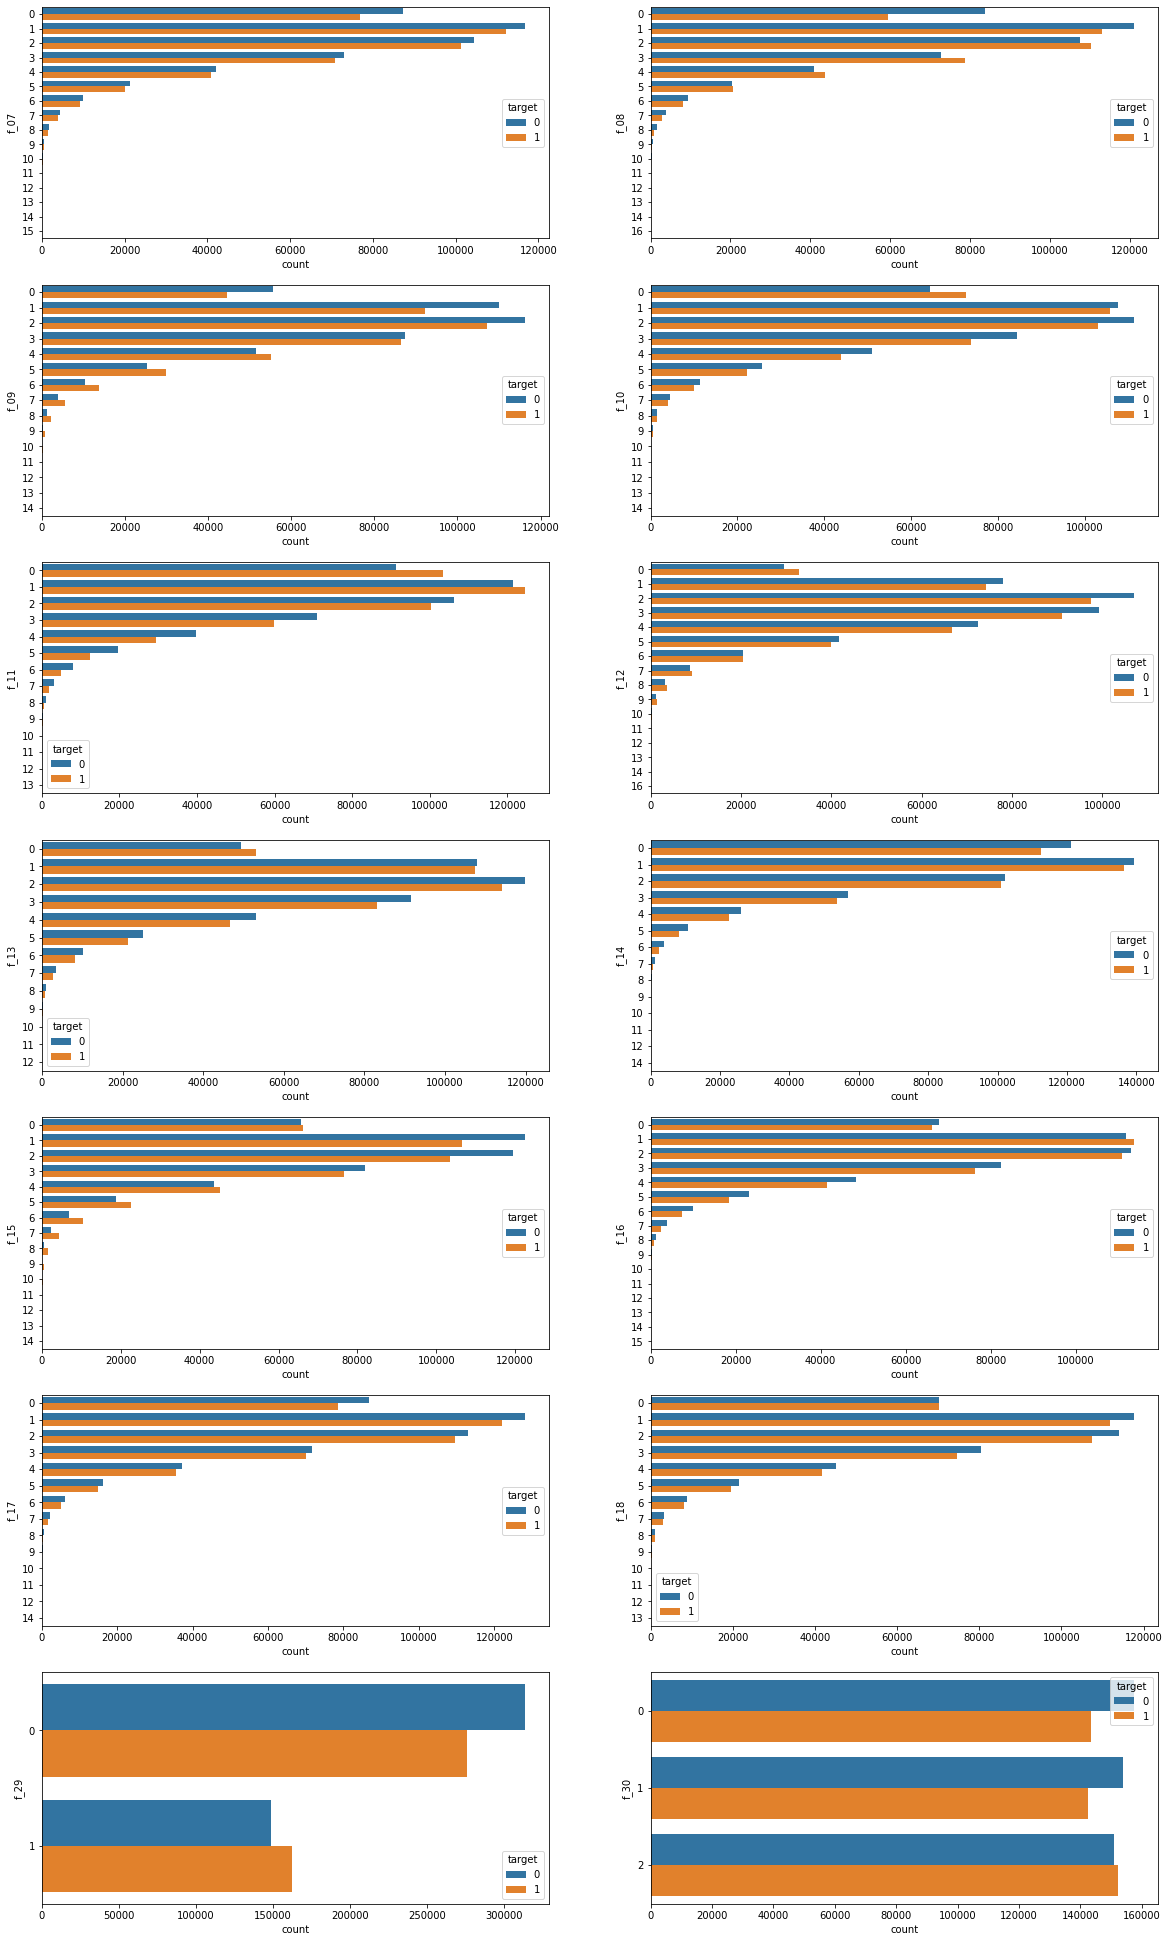

In [84]:
plt.figure(figsize=(20,40))

for i, col in enumerate(feature_cat):
    plt.subplot(int(len(feature_cat)/2)+1, 2, i+1)
    ax = sns.countplot(data=df2_train, y=col, hue=target)    

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
 
Observando os gráficos acima, as variáveis com numeração de  17 à 18 tem pouca quantidade nas ultimas classe, sendo assim, podemos fazer um junção desses classes em outras classas, assim podemos reduzir o ruído na modelagem, outra abordagem que podemos implementar é a transformação **Target Encoding**. 
     
<br>
Vamos dar uma olhada na correlação das variaveis categóricas, para isso foi criado uma função que calcula a matriz de coeficientes de Cramer, que permite entender a correlação entre duas variáveis categóricas em um conjunto de dados.
    
    
</div>

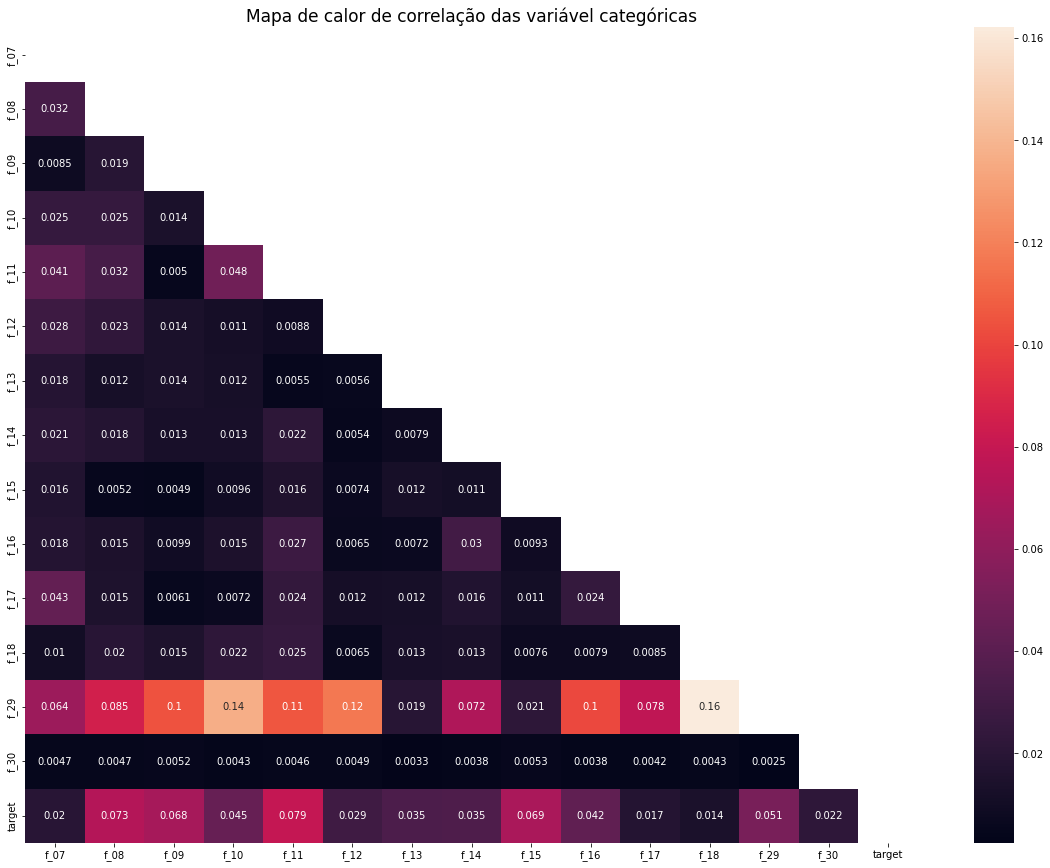

In [95]:
plt.figure(figsize=(20,15))

df         = df2_train[feature_cat].copy()
df[target] = df2_train[target].astype(object)

corr = generate_category_table(df)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask= mask). \
         set_title('Mapa de calor de correlação das variável categóricas', fontsize=17);

del df

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Temos uma correlação baixa entre as variáveis categóricas e principalmente em relação a variável alvo.
    
</div>

## 2.8. Dados Númericos

### 2.8.1. Correlação
Vamos examinar a correlação entre as variáveis.

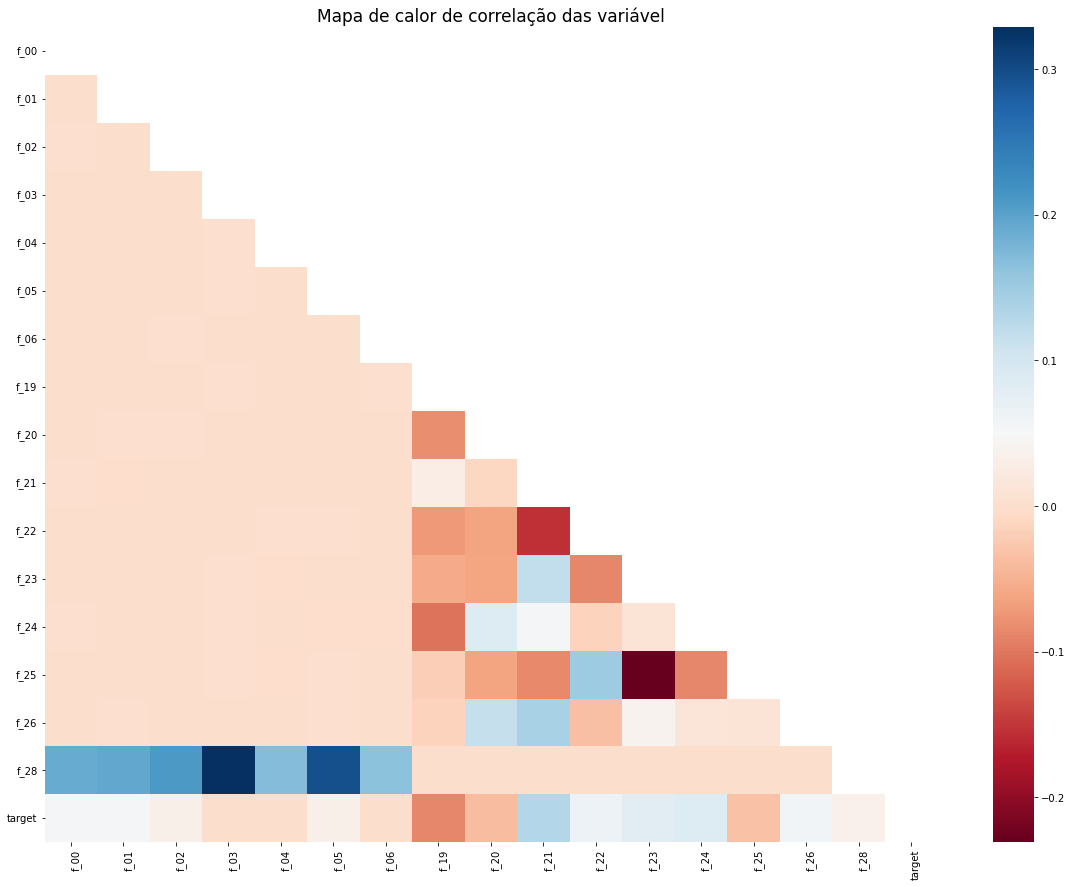

In [97]:
plt.figure(figsize=(20,15))
graf_feature_corr(df=df2_train.copy().drop('id', axis=1), annot_=False, threshold=.7, print_var=False)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Como podemos observar, a correlação fica entre -0.2 e 0.3%, sendo assim, não temos variáveis autocorrelacionadas, mais a frente com a criação de novas variáveis podemos ter variáveis autocorrelacionadas e voltaremos a fazer essa análise de autocorrelação.

    
</div>

### 2.8.2. Histograma

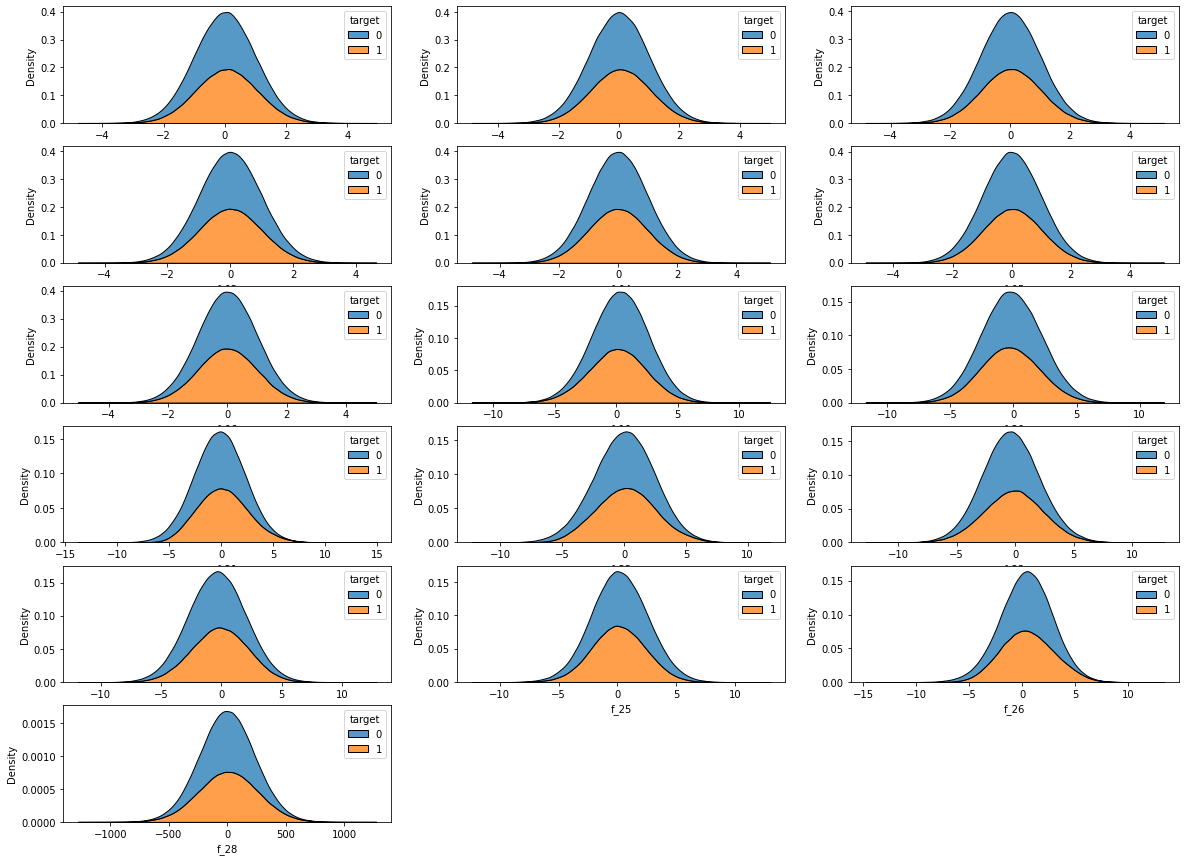

In [56]:
plt.subplots(figsize=(20, 15))

for i, col in enumerate(feature_float):    
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.kdeplot(data=df2_train, x=col, hue=target, legend=True, shade=True, multiple='stack');  

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
- A distribuição das variáveis parecem ser bem comportadas, igual a uma distribuição normal.   
     
<br> 
Vamos dar uma olhda nos outliers dessas variáveis. 
    
</div>

---

### 2.8.3. Outliers

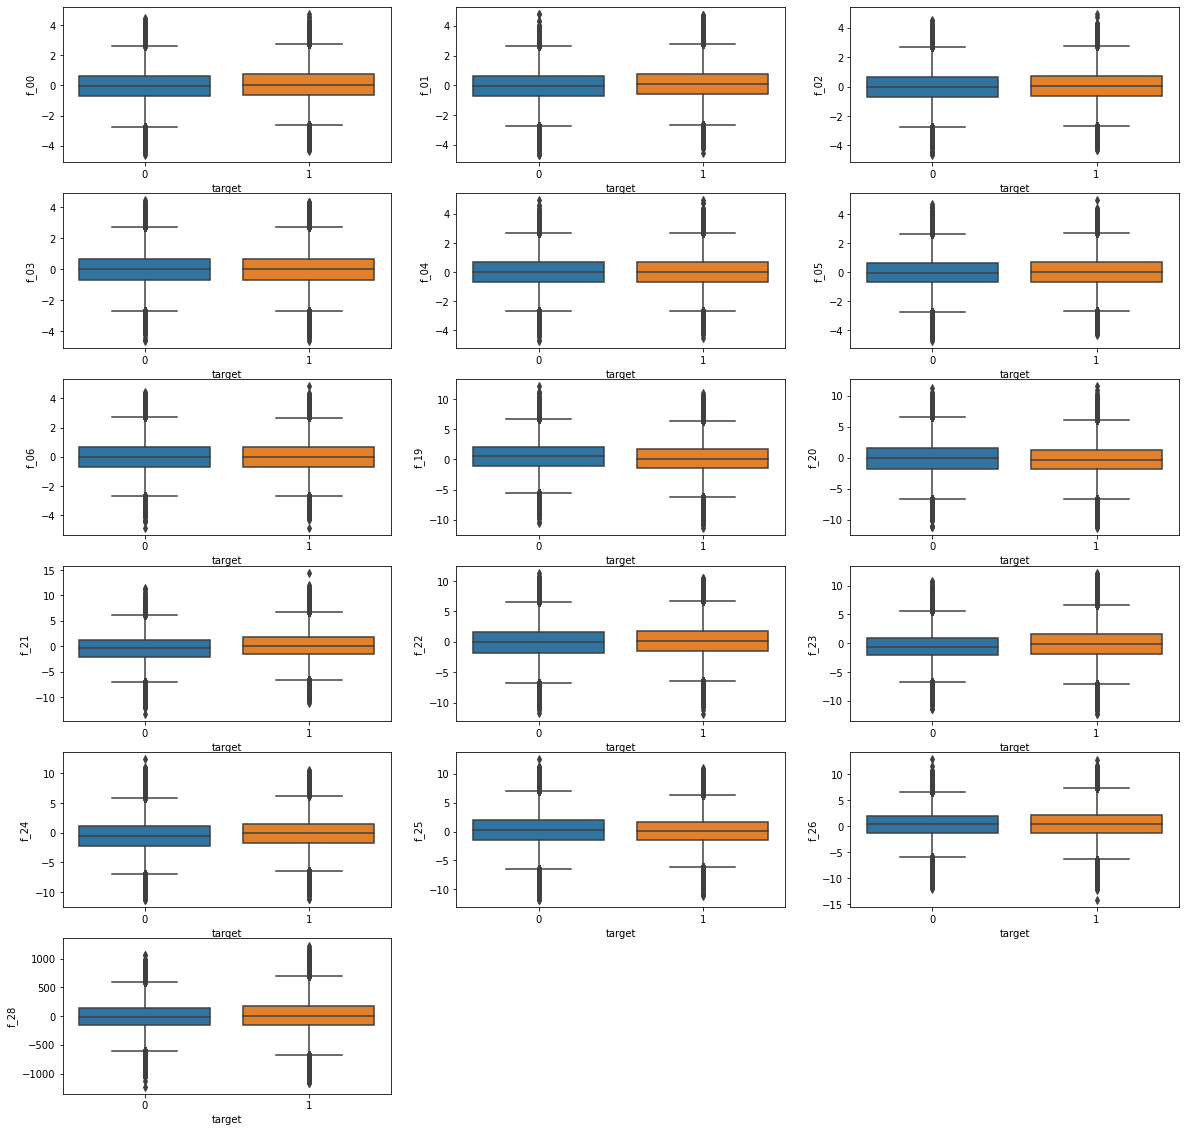

In [98]:
f, ax = plt.subplots(figsize=(20, 20))

for i, col in enumerate(feature_float): 
    plt.subplot(int(len(feature_float)/3 +1),3,i+1)
    sns.boxplot(data=df2_train, x=target, y=col)    

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
- Todas variáveis tem outliers, o bom é que todas as mediana são iguais a zero, provavelmente os modelos de arvosres podem ter melhor desempenho, podemos tentar alguma técnica que identifique os outliers para as variáveis com maior importancia, por exemplo criando uma nova variável que identifique as amostras com outliers.  
    
</div>



# <div class="alert alert-info alert-dismissible">3. Modelagem (baseline)  </div> 


Vamos excluir a variável **f_27** neste primeiro momento, no próximo notebook vamos tratar essa variável.  

In [99]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

df3_train.drop(['f_27'], axis=1 , inplace=True)
df3_test.drop(['f_27'], axis=1 , inplace=True)

for col in df3_train.select_dtypes(object).columns: 
    df3_train[col] = df3_train[col].astype(np.int32)
    df3_test[col] = df3_test[col].astype(np.int32)    

## 3.1. Split Train/Test

In [118]:
X      = df3_train.drop([target, 'id'], axis=1)
y      = df3_train[target]
X_test = df3_test.drop(['id'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((630000, 30), (630000,), (270000, 30), (270000,), (700000, 30))

## 3.2. Parametros do modelo

In [147]:
seed   = 12359
params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : 'auc',  
          'n_estimators'     : 1000,                
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'n_estimators': 1000,
 'random_state': 12359,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

## 3.4. Seleção do Scaler

In [148]:
#path=''

In [150]:
%%time 

scalers = [StandardScaler(),
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(),            
           QuantileTransformer(output_distribution='normal', random_state=0)]

model_baseline = xgb.XGBClassifier(**params)
scaler_best    = None
model_best     = None
cols           = X_test.columns
f1_best        = 0 
auc_best       = 0 

for scaler in scalers: 
    
    X_train_s = X_train.copy() 
    X_valid_s = X_valid.copy()
    
    if scaler!=None:                      
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train_s), columns=cols)
        X_valid_s = pd.DataFrame(scaler.transform(X_valid_s), columns=cols)
        X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=cols)
        
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred_prob_tr = model_baseline.predict_proba(X_train_s)[:,1]
    y_pred_prob_vl = model_baseline.predict_proba(X_valid_s)[:,1]
    y_pred_prob_ts = model_baseline.predict_proba(X_test_s)[:,1]
    
    y_pred_tr = (y_pred_prob_tr>.5).astype(int) 
    y_pred_vl = (y_pred_prob_vl>.5).astype(int)

    f1     = metrics.f1_score(y_valid, y_pred_vl)
    auc_vl = metrics.roc_auc_score(y_valid, y_pred_prob_vl)
    auc_tr = metrics.roc_auc_score(y_train, y_pred_prob_tr)
        
    print('AUC Trn: {:2.5f} - AUC Val: {:2.5f} - F1: {:2.5f} => {}'.format(auc_tr, auc_vl, f1, scaler))
    
    if auc_vl>auc_best:
        f1_best     = f1    
        auc_best    = auc_vl
        scaler_best = scaler
        model_best  = model_baseline
        
    # Gera arquivo de submissão
    name_file_sub         = 'xgb_base_line_01_score_{:2.5f}_{}.csv'.format(auc_vl,str(scaler).lower()[:4])
    df_submission[target] = y_pred_prob_ts
    
    df_submission.to_csv(path + 'Data/submission/' + name_file_sub, index=False)

del scaler, f1, auc_vl
    
print()
print('The Best')  
print('Scaler: {}'.format(scaler_best))    
print('AUC   : {:2.5f}'.format(auc_best))
print()

AUC Trn: 0.97547 - AUC Val: 0.93120 - F1: 0.86525 => StandardScaler()
AUC Trn: 0.97547 - AUC Val: 0.93120 - F1: 0.86525 => RobustScaler()
AUC Trn: 0.97547 - AUC Val: 0.93120 - F1: 0.86525 => MinMaxScaler()
AUC Trn: 0.97547 - AUC Val: 0.93120 - F1: 0.86525 => MaxAbsScaler()
AUC Trn: 0.97563 - AUC Val: 0.93122 - F1: 0.86498 => QuantileTransformer(output_distribution='normal', random_state=0)

The Best
Scaler: QuantileTransformer(output_distribution='normal', random_state=0)
AUC   : 0.93122

CPU times: total: 5min 32s
Wall time: 5min 5s


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Podemos observar que a maioria dos scalers não tem efeito neste conjunto de dados utilizando o XGB, no nosso caso o melhor scaler foi **QuantileTransformer**. 
        
</div>

### 3.3.2. Featuere Importance

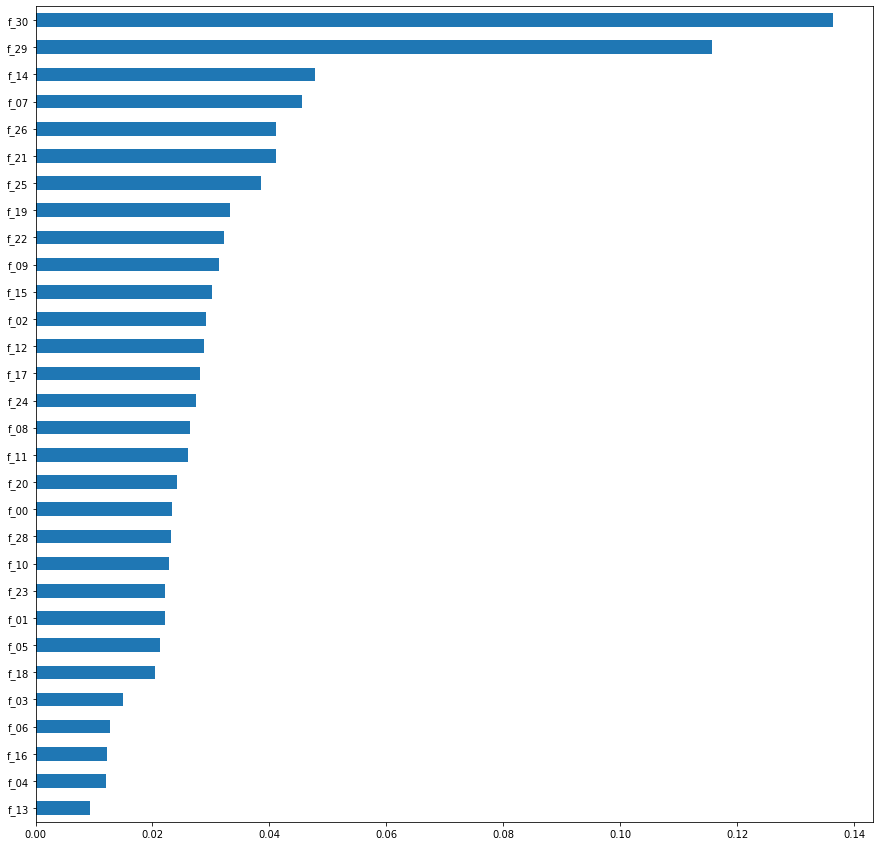

In [123]:
features       = pd.Series(model_baseline.feature_importances_)
features.index = cols

features.sort_values(ascending=True, inplace=True)
features.plot(kind ='barh', figsize=(15,15));

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Olhando as variáveis mais importante, obeservamos que a maioria das variáveis que identificamos como categoricas aparecem entre as mais importantes.  
    
</div>

## 3.4. Validação Cruzada

In [124]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0
   # col_prob        = y_.sort_values().unique()
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    test_pred_proba = np.zeros((1, 1))
    preds           = []
    model           = []
    
    for i, scaler_ in enumerate(scalers_): 

        time_start = datetime.now()
        score      = []        
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        pred_test=0 
        
        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)[:,1]    
            y_pred_val      = (y_pred_val_prob>.5).astype(int)

            preds.append(model_.predict(X_tst))    
            
            pred_test += model_.predict_proba(X_tst)[:, 1] / folds.n_splits
                
            df_prob_temp    = pd.DataFrame(y_pred_val_prob)
            #y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx            
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = y_pred_val_prob
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
            f1    = metrics.f1_score(y_val, y_pred_val) 
            prec  = metrics.log_loss (y_val, y_pred_val)
            
            score.append(auc)     
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['auc_'+str(fold+1)] = auc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
            print(msg.format(fold+1, auc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)

        score_mean = np.mean(score) 
        score_std  = np.std(score)

        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] AUC: {:2.5f} std: {:2.5f} - {}'.format(score_mean, score_std, time_end))
        print('='*taco)
        print()
               
        if save_submission_:
            name_file_sub  = model_name_ + '_' + str(i+1) + '_' + str(scaler_).lower()[:4] + '.csv'
            name_file_sub  = path_ + 'Data/submission/' + name_file_sub.format(score_mean)        
            df_sub         = df_submission.copy()
            df_sub[target] = pred_test
            df_sub.to_csv(name_file_sub, index=False)
            
        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model, df_prob_temp.sort_values(by=['scaler','id']) , feature_imp 

In [153]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error']                 
scalers     = [StandardScaler(), 
               QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : 1000,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X,
                    y_               = y,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = True)
print()

Scaler: StandardScaler - n_estimators: 1000
[Fold 1] AUC: 0.93365 - F1-score: 0.86825 - L. Loss: 4.39587  - 0h 0m 50s
[Fold 2] AUC: 0.93219 - F1-score: 0.86775 - L. Loss: 4.42255  - 0h 0m 44s
[Fold 3] AUC: 0.93327 - F1-score: 0.86849 - L. Loss: 4.39971  - 0h 1m 0s
[Fold 4] AUC: 0.93219 - F1-score: 0.86671 - L. Loss: 4.45363  - 0h 0m 52s
[Fold 5] AUC: 0.93261 - F1-score: 0.86739 - L. Loss: 4.43675  - 0h 0m 40s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.93278 std: 0.00059 - 0h 4m 9s

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     92432
           1       0.87      0.86      0.87     87568

    accuracy                           0.87    180000
   macro avg       0.87      0.87      0.87    180000
weighted avg       0.87      0.87      0.87    180000

Scaler: QuantileTransformer - n_estimators: 1000
[Fold 1] AUC: 0.93325 - F1-score: 0.86746 - L. Loss: 4.42140  - 0h 1m 4s
[Fold 2] AU

## 3.5. Análise do Modelo 
Vamos fazer o treinamento novamente do melhor modelo, sendo que agora vamos utilizar a divisão de treino/teste, isto é, vamos o treino em um conjunto de dados e fazer a previsões em dados que o modelo não viu no treino. 

In [127]:
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

model, df_proba, feature_imp = \
    cross_val_model(model_           = xgb.XGBClassifier(**params),
                    model_name_      = 'xgb_bs_vc_score_02_{:2.5f}',
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5, 
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None, 
                    print_report_    = True, 
                    save_submission_ = False)
print()

Scaler: QuantileTransformer - n_estimators: 1000
[Fold 1] AUC: 0.93091 - F1-score: 0.86502 - L. Loss: 4.51284  - 0h 0m 38s
[Fold 2] AUC: 0.93067 - F1-score: 0.86516 - L. Loss: 4.50270  - 0h 0m 35s
[Fold 3] AUC: 0.93085 - F1-score: 0.86383 - L. Loss: 4.55424  - 0h 0m 45s
[Fold 4] AUC: 0.93146 - F1-score: 0.86522 - L. Loss: 4.50791  - 0h 0m 47s
[Fold 5] AUC: 0.92919 - F1-score: 0.86204 - L. Loss: 4.60221  - 0h 0m 37s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.93062 std: 0.00076 - 0h 3m 24s

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     64703
           1       0.87      0.86      0.86     61297

    accuracy                           0.87    126000
   macro avg       0.87      0.87      0.87    126000
weighted avg       0.87      0.87      0.87    126000

----------------------------------------------------------------------------
Scaler Best: QuantileTransformer(output_distribut

### 3.5.1. Feature Importances  

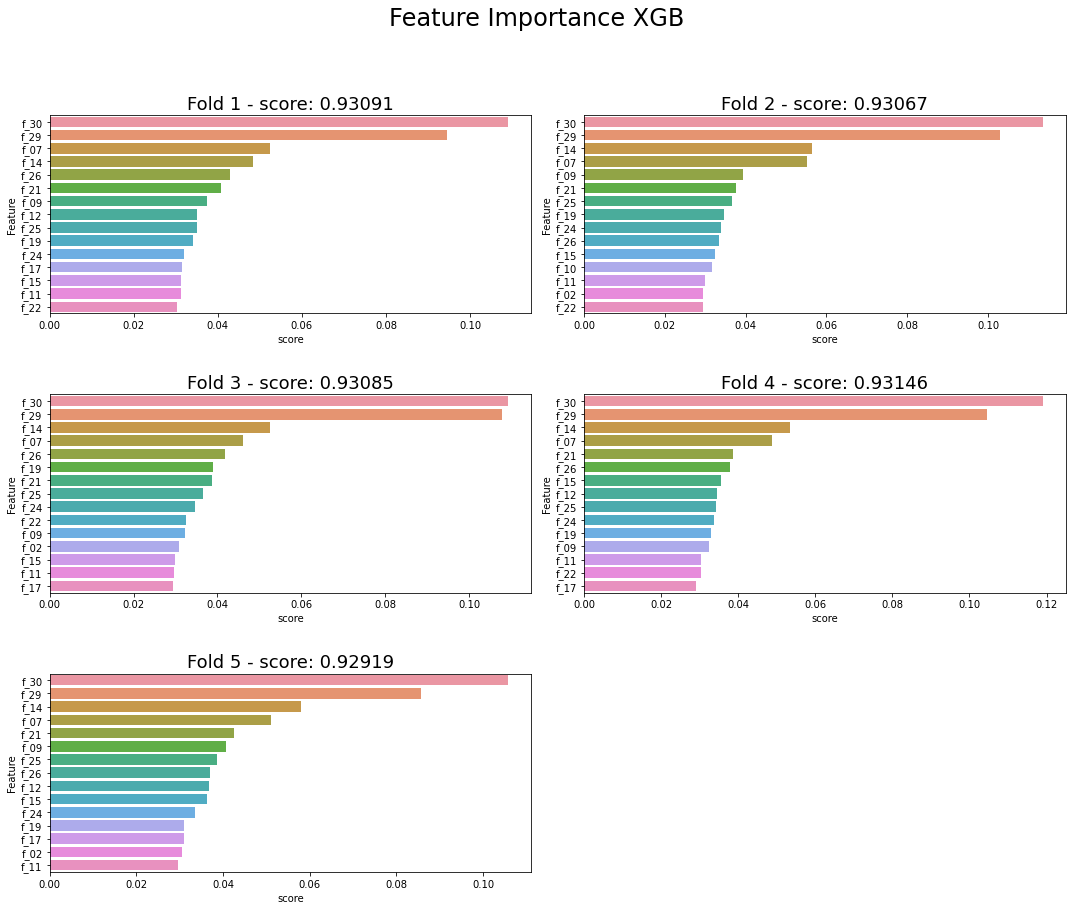

In [128]:
plt.figure(figsize=(15,12))
for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'auc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(3,2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

### 3.5.2. Shap

In [129]:
mdl = model[1]['model']
sc  = model[1]['scaler']

X_valid_sc = sc.transform(X_valid)#, columns=X_valid.columns)
y_pred_val = mdl.predict_proba(X_valid_sc)[:,1]
score      = metrics.roc_auc_score(y_valid, y_pred_val)

print('AUC em dados não viscto: {:2.5f}'.format(score))

AUC em dados não viscto: 0.92946


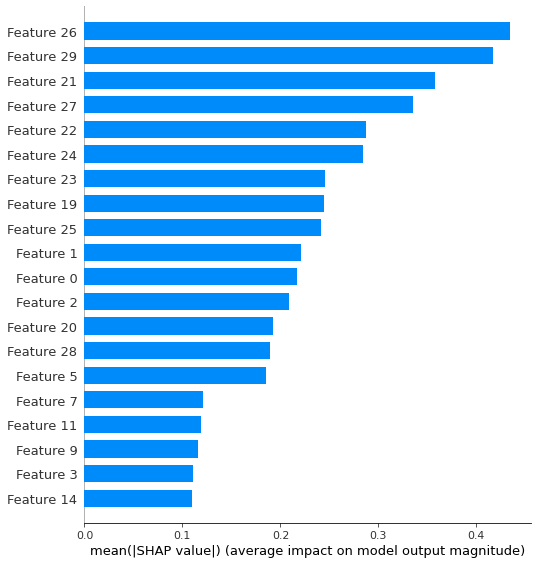

In [130]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_valid_sc)

shap.summary_plot(shap_values, X_valid_sc, plot_type="bar")

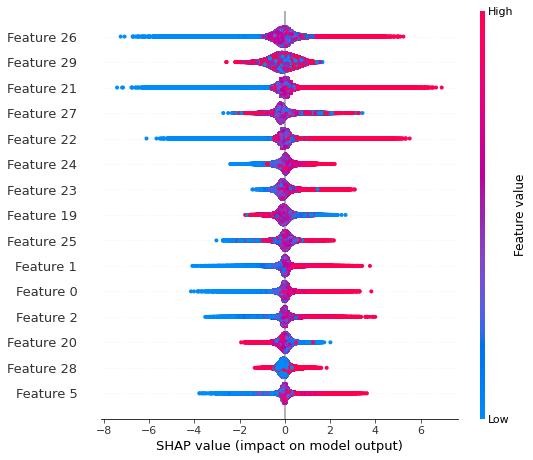

In [131]:
shap.summary_plot(shap_values, X_valid_sc, max_display=15)

### 3.1.1. Erro e  número de Estimadores

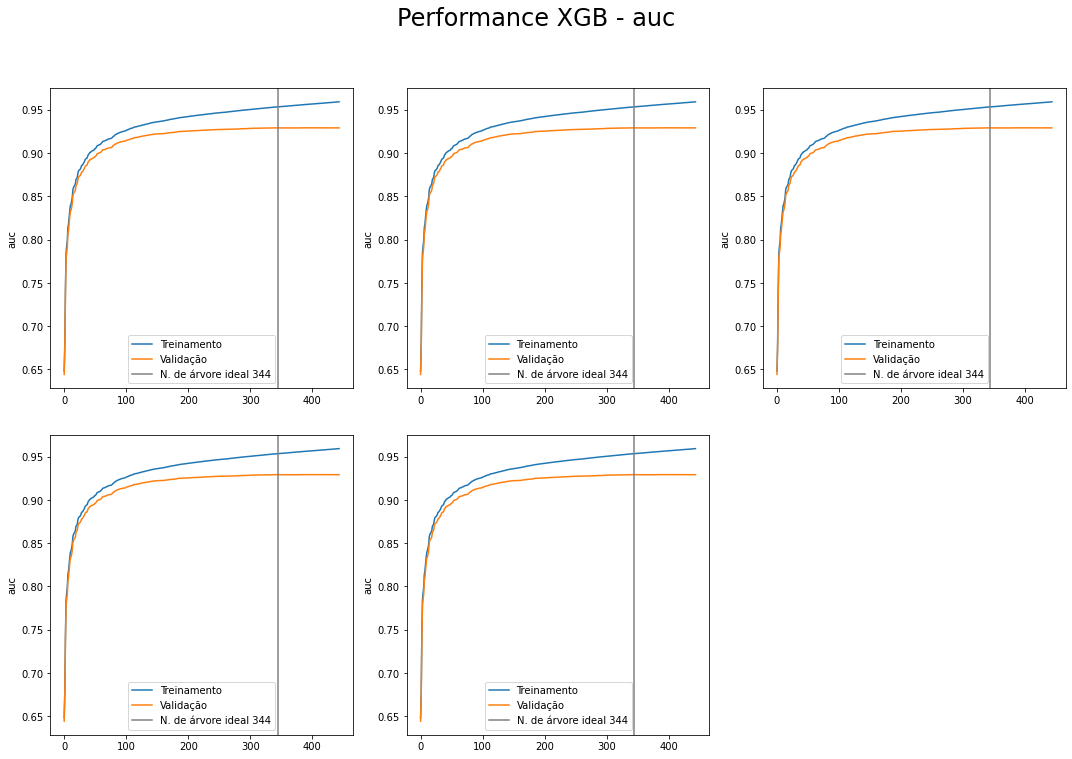

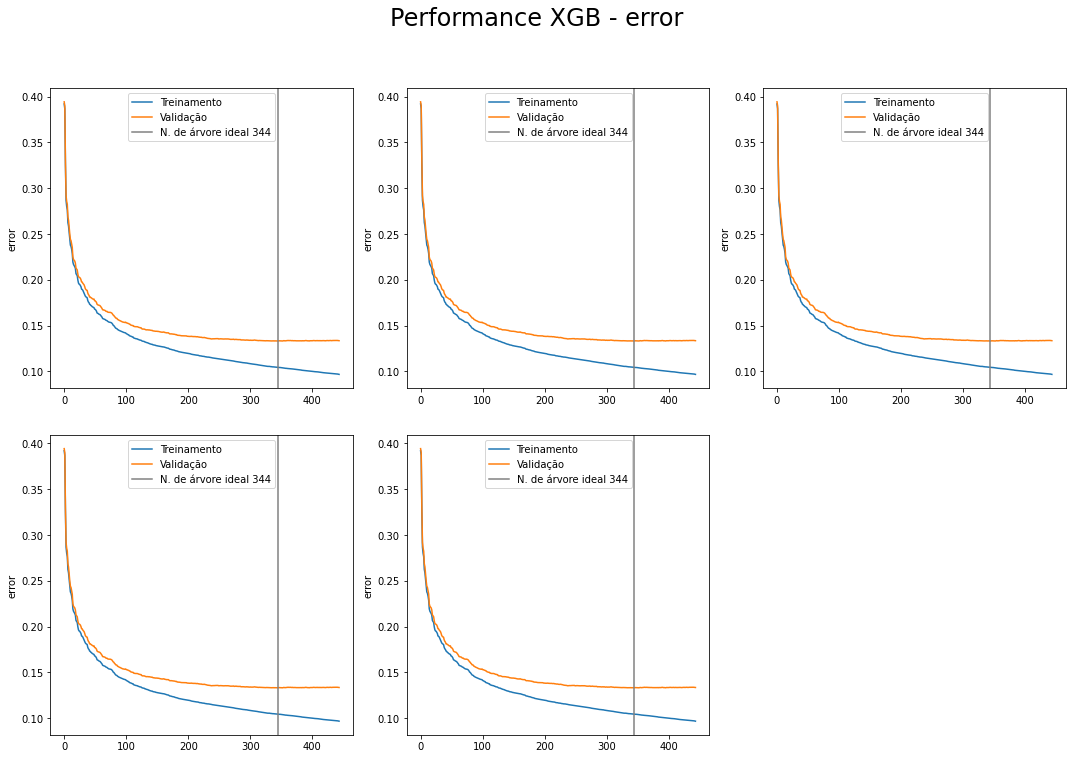

In [132]:
for erro in eval_metric:
    plt.figure(figsize=(15,10))

    for i in range(len(model)):
        results     = model[i]['model'].evals_result() # merror
        ntree_limit = model[i]['model'].best_ntree_limit

        plt.subplot(2,3,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

       # plt.xlabel('Número de árvores')
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 1000 estimadores é mais que suficiente para o treinamento do modelo, já na predição utilizamos 536 estimadores que torna as predições mais performáticas, esse parametro pode ajuda na tunning do XGB.  
    
</div>

### 3.1.2. Previsão 

In [133]:
scaler_tr  = model[1]['scaler']
model_tr   = model[1]['model']
X_valid_sc = pd.DataFrame(scaler_tr.transform(X_valid), columns=X_valid.columns)

y_pred_prob = model_tr.predict_proba(X_valid_sc.values, ntree_limit=model_tr.best_ntree_limit)[:,1]
y_pred      = (y_pred_prob >.5).astype(int)
auc         = metrics.roc_auc_score(y_valid, y_pred_prob)

print('AUC: {:2.5f}'.format(auc))

AUC: 0.92946


### 3.1.3. Matriz de Confusão

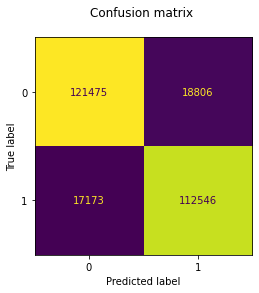

In [134]:
def plot_cm(preds,true,ax=None):
    cm = confusion_matrix(preds.round(), true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False, values_format = '.6g')
    plt.title('Confusion matrix \n')
    plt.grid(False)
    return disp

plot_cm(y_pred, y_valid);

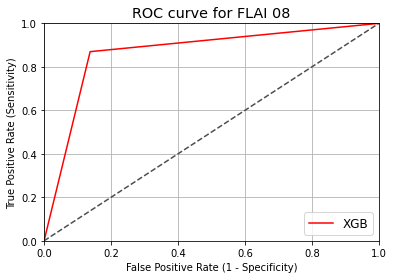

AUC     : 0.92946 
F1-score: 0.86219
F1-score: 0.86335 threshold(0.47)


In [135]:
threshold = .47

y_pred_threshold     = (y_pred_prob>threshold).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_threshold)

plot_roc_curve(fpr, tpr, label="XGB")
plt.show()

print('AUC     : {:2.5f} '.format(metrics.roc_auc_score(y_valid, y_pred_prob) ))
print('F1-score: {:2.5f}'.format(metrics.f1_score(y_valid, y_pred)))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y_valid, y_pred_threshold), threshold))

<div class="alert alert-info" role="alert"> 
  
CONCLUSÃO: <BR>
Agora temos uma noção do conjunto de dados para esse competição e uma linha de base com o classificador XGB, que se mostrou promissor nas submissões, obtive os sequintes resultados: 0.93628 e 0.93935 todos melhores que o treinamento do modelo, isso demostra que o modelo é robusto e teve uma boa generalização nos dados de teste que tem aproximadamente 29% dos dados, esse é um ponto importante que temos que considerar, pois no final da competição nosso modelo terá que ter um performance em todo o conjunto de dados. 
    
    
Os próximos passos são: <br>

- Feature Engineering     
Ainda há muito a explorar dentro do conjunto de dados, recomendo explorar as variáveis que se relacionam com a variável de destino. Com base nessas relações, podemos criar mais variáveis que são combinações de dois ou mais variaveis. Um exemplo seria a variável C que é formada pelas variáveis A x B. Além disso, a variável f_27 precisa ser examinada com mais detalhes. Pode haver informações importantes escondidas em todos essas variáveis aparentemente sem sentido; 
<br>
    
- Tunning de hyperparametros     
Neste notebook não nos aprofundamos no tunning de hyperparametro do classificado XGB, é outro ponto importante mesmo que o ganho seja pouco, o tunning faz com que os modelos se tornem mais robusto e qualquer ganho pode melhora a nosso colocação na competição;
    
   
    
</div>